In [1]:
#!aws s3 cp s3://amazon-reviews-pds/tsv/amazon_reviews_us_Camera_v1_00.tsv.gz .
#https://gist.github.com/iamaziz/5e4e85e9d63ff8d12f2848938fec7b0a

### Refer https://github.com/mnguyenngo/flask-rest-setup/tree/master/notebooks

In [2]:
!aws s3 ls --recursive s3://ca-mlflow-v1/Development/ --summarize

2022-04-25 10:54:04          0 Development/
2022-04-26 05:35:36    3367149 Development/test.tsv
2022-04-26 05:35:35    8481022 Development/train.tsv

Total Objects: 3
   Total Size: 11848171


In [3]:
#!pip install h5py 
#!pip install typing-extensions 
#!pip install wheel

In [4]:
#!pip install mlflow

In [5]:
import io
import os
import boto3
import pandas as pd
import s3fs

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.style.use('ggplot')


In [6]:
import joblib

In [7]:
bucket='ca-mlflow-v1'
train_file_key = 'Development/train.tsv'
s3uri = 's3://{}/{}'.format(bucket, train_file_key)


In [8]:
s3uri

's3://ca-mlflow-v1/Development/train.tsv'

In [9]:
data = pd.read_csv(s3uri,sep='\t')

In [10]:
data.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


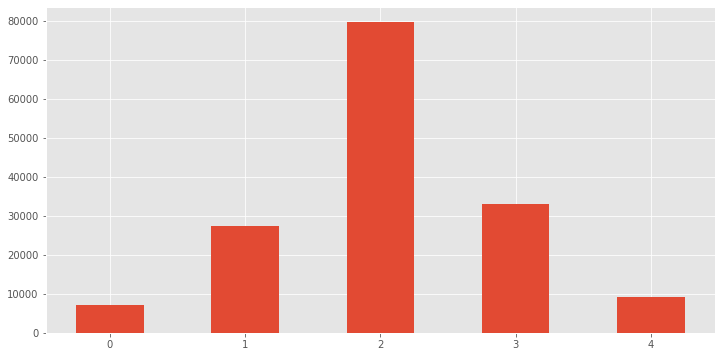

In [11]:
num_unique = len(data['Sentiment'].unique())
data['Sentiment'].hist(figsize=(12,6), bins=np.arange(num_unique+1)-0.5, rwidth=0.5)

## Building Model

In [12]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

import pickle


In [13]:
clf = MultinomialNB()
vectorizer = TfidfVectorizer()

#### Use only the 1 star and 5 star reviews

In [14]:
pos_neg = data[(data['Sentiment'] == 0) | (data['Sentiment'] == 4)]


#### Relabel as 0 for negative and 1 for positive


In [15]:
pos_neg['Binary'] = pos_neg.apply(
    lambda x: 0 if x['Sentiment'] == 0 else 1, axis=1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#### Log To MLFlow

In [22]:
'''
    def predict(self, context, model_input):
        uq_vectorized = self.vectorizer_transform(np.array([model_input]))
        prediction = self.model.predict(uq_vectorized)
        pred_proba = self.model.predict_proba(uq_vectorized)

        # Output either 'Negative' or 'Positive' along with the score
        if prediction == 0:
            pred_text = 'Negative'
        else:
            pred_text = 'Positive'

        # round the predict proba value and set to new variable
        confidence = round(pred_proba[0], 3)

        # create JSON object
        output = {'prediction': pred_text, 'confidence': confidence}

        return output
'''

"\n    def predict(self, context, model_input):\n        uq_vectorized = self.vectorizer_transform(np.array([model_input]))\n        prediction = self.model.predict(uq_vectorized)\n        pred_proba = self.model.predict_proba(uq_vectorized)\n\n        # Output either 'Negative' or 'Positive' along with the score\n        if prediction == 0:\n            pred_text = 'Negative'\n        else:\n            pred_text = 'Positive'\n\n        # round the predict proba value and set to new variable\n        confidence = round(pred_proba[0], 3)\n\n        # create JSON object\n        output = {'prediction': pred_text, 'confidence': confidence}\n\n        return output\n"

In [34]:
class ClfWrapper(mlflow.pyfunc.PythonModel):
    def __init__(self,model,vectorizer):
        self.model=model
        self.vectorizer=vectorizer   
        
    def predict(self, context, model_input):
        uq_vectorized = self.vectorizer_transform(np.array([model_input]))
        prediction = self.model.predict(uq_vectorized)
        pred_proba = self.model.predict_proba(uq_vectorized)
        return prediction
        

In [53]:
import mlflow
from mlflow.models.signature import infer_signature
from sklearn.metrics import roc_auc_score

tracking_uri="http://3.110.204.41:5000"
experiment_name="mlflow_sagemaker_exp_2"
mlflow.set_tracking_uri(tracking_uri)
mlflow.set_experiment(experiment_name)


<Experiment: artifact_location='s3://ca-mlflow-v1/mlflow/2', experiment_id='2', lifecycle_stage='active', name='mlflow_sagemaker_exp_2', tags={}>

In [54]:
with mlflow.start_run(run_name="test_sagemaker"):
    
    X_train_tfidf=vectorizer.fit_transform(pos_neg.loc[:, 'Phrase'])
    y = pos_neg.loc[:, 'Binary']
    X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, y)
    
    clf = MultinomialNB().fit(X_train, y_train)
    predictions_test = clf.predict(X_test)
    auc_score = roc_auc_score(y_test, predictions_test)
    #mlflow.log_metric('auc', auc_score)
    wrappedmodule=ClfWrapper(clf,vectorizer)
    mlflow.pyfunc.log_model("nlp_model", python_model=wrappedmodule)